In [1]:
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import numpy as np
# Import physical constants such as the speed of light
import scipy.constants as consts

In [2]:
header_names = ['#errors',
                'scan#', 
                'motor-target_1', # Delay axis-1
                'motor-target_2', # Delay axis-2
                'motor-actual_1',
                'motor-actual_2',
                'data_channel_0',
                'data_channel_1', 
                'data_channel_2',
                'data_channel_3',
                'data_channel_4',
                'data_channel_5',
                'data_channel_6',
                'data_channel_7']

data = pd.read_csv('../data/trial_output05.tsv', delimiter='\t', names = header_names)

In [23]:
data_cols = [col_name for col_name in data if 'data_channel' in col_name]
signal_df = data[data_cols]
v_min = min(signal_df.min())
v_max = max(signal_df.max())
display(v_min, v_max)

-0.063398

1.8273009999999998

#### Check that all is copacetic

In [4]:
# motor-target_1: 67-rows, (9.215, 9.413)
# motor-target_2: 58-rows, (33.340, 33.511)
data.describe()

,#errors,scan#,motor-target_1,motor-target_2,motor-actual_1,motor-actual_2,data_channel_0,data_channel_1,data_channel_2,data_channel_3,data_channel_4,data_channel_5,data_channel_6,data_channel_7
count,45628.0,45628.000000,45628.000000,45628.000000,45628.000000,45628.000000,45628.000000,45628.000000,45628.000000,45628.000000,45628.000000,45628.000000,45628.000000,45628.000000
mean,0.0,5.378978,9.314018,33.425522,9.314025,33.425522,-0.005923,-0.006613,-0.006294,-0.006124,-0.007194,-0.006101,-0.021113,0.004937
std,0.0,3.390998,0.058022,0.050232,0.058011,0.050232,0.006699,0.022854,0.005250,0.010072,0.022253,0.009477,0.014158,0.015740
min,0.0,0.000000,9.215000,33.340000,9.215000,33.340000,-0.032503,-0.063398,-0.031538,-0.047629,-0.058893,-0.037974,-0.032503,-0.025745
25%,0.0,2.000000,9.263000,33.382000,9.263000,33.382000,-0.010298,-0.027033,-0.009654,-0.013194,-0.027033,-0.012229,-0.022849,0.003219
50%,0.0,5.000000,9.314000,33.427000,9.314000,33.427000,-0.006436,-0.008689,-0.006436,-0.007080,-0.009976,-0.007401,-0.021240,0.004828
75%,0.0,8.000000,9.365000,33.469000,9.365000,33.469000,-0.000965,0.012873,-0.002252,0.000644,0.011586,0.001288,-0.019631,0.006115
max,0.0,11.000000,9.413000,33.511000,9.413100,33.511000,0.018022,0.059537,0.016735,0.039906,0.056963,0.025424,1.671540,1.827301


### Identify number of complete scans performed

In [5]:
# There are 58*67 = 3,886 samples per scan
# Note: (3,886*11 SCANS) + 2,882 = 45,628 TOTAL Samples
# Notice 11 complete scans (Scan '11.0' incomplete)
# Scans are averaged together, homodyne OKE results
data['scan#'].value_counts().sort_index()

0.0     3886
1.0     3886
2.0     3886
3.0     3886
4.0     3886
5.0     3886
6.0     3886
7.0     3886
8.0     3886
9.0     3886
10.0    3886
11.0    2882
Name: scan#, dtype: int64

In [6]:
# No errors identified in 45,628 measurements!
# An error may consist of a communication error b/w motor & acquisition computer
# Motors will be reinitialized, and the scan is restarted
data['#errors'].value_counts()

0.0    45628
Name: #errors, dtype: int64

In [7]:
# There are 67-motor_1 positions each with b/w 670(9.245)-689(9.236) samples taken
# Motor_1 positions range (9.215, 9.413)
data['motor-target_1'].value_counts().sort_index()

9.215    682
9.218    681
9.221    679
9.224    684
9.227    685
        ... 
9.401    680
9.404    683
9.407    681
9.410    677
9.413    680
Name: motor-target_1, Length: 67, dtype: int64

---
### Conversion from distance traveled to time taken to travel the distance
#### [millimeters] --> [femtoseconds]
##### A) Axis-1: T --> Delay between the excitation(pump) pulse and subsequent pulses

In [8]:
# Step-size for delay axis-1
# Why is the range of delay greater for T than Tau?
step_1 = (max(data['motor-target_1'])-min(data['motor-target_1']))/len(data['motor-target_1'].value_counts())

# Time [femtoseconds] it takes light to travel twice the distance "step_1"
step_1_time = ((step_1*2)/(consts.c*1000))/(1E-15)

print(f'Delay Axis-1 step-size: {step_1:.5f}[mm]')
print(f'Delay Axis-1 step-size: {step_1_time:.4f}[fs]')

Delay Axis-1 step-size: 0.00296[mm]
Delay Axis-1 step-size: 19.7151[fs]


##### B) Axis-2: Tau --> Delay between Kerr-Gating(drive) pulse and probe pulse

In [9]:
# Step-size for delay axis-2
step_2 = (max(data['motor-target_2'])-min(data['motor-target_2']))/len(data['motor-target_2'].value_counts())

# Time [femtoseconds] it takes light to travel twice the distance "step_2"
step_2_time = ((step_2*2)/(consts.c*1000))/(1E-15)

print(f'Delay Axis-2 step-size: {step_2:.5f}[mm]')
print(f'Delay Axis-2 step-size: {step_2_time:.4f}[fs]')

Delay Axis-2 step-size: 0.00295[mm]
Delay Axis-2 step-size: 19.6688[fs]


---

In [10]:
#data = data.drop(columns=['#errors', 'scan#'])

In [11]:
# Average all scans together
data_mean = data.groupby(['motor-target_1', 'motor-target_2']).mean()
print('Averaged Data: Delay Axis-1 Primary')
display(data_mean)

data_mean2 = data.groupby(['motor-target_2', 'motor-target_1']).mean()
print('Averaged Data: Delay Axis-2 Primary')
display(data_mean2)

Averaged Data: Delay Axis-1 Primary


#errors  scan#  motor-actual_1  motor-actual_2  \
motor-target_1 motor-target_2                                                   
9.215          33.340              0.0    5.0        9.215036          33.340   
               33.343              0.0    5.5        9.215033          33.343   
               33.346              0.0    5.5        9.215025          33.346   
               33.349              0.0    5.5        9.215008          33.349   
               33.352              0.0    5.5        9.215050          33.352   
...                                ...    ...             ...             ...   
9.413          33.499              0.0    5.5        9.413000          33.499   
               33.502              0.0    5.0        9.413000          33.502   
               33.505              0.0    5.0        9.413000          33.505   
               33.508              0.0    5.5        9.412992          33.508   
               33.511              0.0    5.0        9.413000          33.511   

                               data_channel_0  data_channel_1  data_channel_2  \
motor-target_1 motor-target_2                                                   
9.215          33.340               -0.009157       -0.001375       -0.004885   
               33.343               -0.002789        0.003701       -0.005765   
               33.346               -0.005283       -0.003084       -0.005658   
               33.349               -0.010137       -0.013489       -0.005900   
               33.352               -0.007884       -0.021374       -0.007079   
...                                       ...             ...             ...   
9.413          33.499               -0.007026        0.000295       -0.005256   
               33.502               -0.004973       -0.010444       -0.006026   
               33.505               -0.008338       -0.001989       -0.002428   
               33.508               -0.005685       -0.011853       -0.007267   
               33.511               -0.010766       -0.013750       -0.004944   

                               data_channel_3  data_channel_4  data_channel_5  \
motor-target_1 motor-target_2                                                   
9.215          33.340                0.001171       -0.005061       -0.007782   
               33.343               -0.008689       -0.019577       -0.008823   
               33.346               -0.007267       -0.009842       -0.008608   
               33.349               -0.002226        0.005552       -0.004746   
               33.352               -0.006731        0.003996       -0.001930   
...                                       ...             ...             ...   
9.413          33.499               -0.004773       -0.006570       -0.008394   
               33.502               -0.011468       -0.010678       -0.006992   
               33.505                0.001873        0.000995       -0.007343   
               33.508               -0.005792       -0.001072       -0.005336   
               33.511                0.000790        0.006203       -0.003920   

                               data_channel_6  data_channel_7  
motor-target_1 motor-target_2                                  
9.215          33.340               -0.022000        0.004272  
               33.343               -0.021830        0.004345  
               33.346               -0.021696        0.004533  
               33.349               -0.021240        0.004533  
               33.352               -0.020730        0.005176  
...                                       ...             ...  
9.413          33.499               -0.021722        0.004372  
               33.502               -0.021503        0.004623  
               33.505               -0.020538        0.005559  
               33.508               -0.020891        0.004560  
               33.511               -0.021006        0.004857  

[3886 rows x 12 columns]

Averaged Data: Delay Axis-2 Primary


#errors  scan#  motor-actual_1  motor-actual_2  \
motor-target_2 motor-target_1                                                   
33.340         9.215               0.0    5.0        9.215036          33.340   
               9.218               0.0    5.5        9.218017          33.340   
               9.221               0.0    5.0        9.221009          33.340   
               9.224               0.0    5.5        9.224067          33.340   
               9.227               0.0    5.5        9.227025          33.340   
...                                ...    ...             ...             ...   
33.511         9.401               0.0    5.5        9.401000          33.511   
               9.404               0.0    5.5        9.403992          33.511   
               9.407               0.0    5.5        9.407000          33.511   
               9.410               0.0    5.0        9.410000          33.511   
               9.413               0.0    5.0        9.413000          33.511   

                               data_channel_0  data_channel_1  data_channel_2  \
motor-target_2 motor-target_1                                                   
33.340         9.215                -0.009157       -0.001375       -0.004885   
               9.218                -0.007536       -0.017968       -0.007053   
               9.221                -0.006758       -0.012551       -0.007489   
               9.224                -0.008635       -0.014776       -0.008206   
               9.227                -0.003915        0.000698       -0.005739   
...                                       ...             ...             ...   
33.511         9.401                -0.007938       -0.013221       -0.007187   
               9.404                -0.006356       -0.003057       -0.003861   
               9.407                -0.004612       -0.004934       -0.005095   
               9.410                -0.003803       -0.009508       -0.007811   
               9.413                -0.010766       -0.013750       -0.004944   

                               data_channel_3  data_channel_4  data_channel_5  \
motor-target_2 motor-target_1                                                   
33.340         9.215                 0.001171       -0.005061       -0.007782   
               9.218                -0.010083       -0.004559       -0.004237   
               9.221                -0.007519       -0.002662       -0.005471   
               9.224                -0.003540        0.005445       -0.001260   
               9.227                -0.007053       -0.006409       -0.007616   
...                                       ...             ...             ...   
33.511         9.401                -0.003647        0.001100       -0.002976   
               9.404                -0.006436       -0.004666       -0.008152   
               9.407                -0.004827       -0.007428       -0.006302   
               9.410                -0.006816       -0.007957       -0.003978   
               9.413                 0.000790        0.006203       -0.003920   

                               data_channel_6  data_channel_7  
motor-target_2 motor-target_1                                  
33.340         9.215                -0.022000        0.004272  
               9.218                -0.021025        0.004962  
               9.221                -0.020245        0.005881  
               9.224                -0.021508        0.004104  
               9.227                -0.020677        0.005471  
...                                       ...             ...  
33.511         9.401                -0.020677        0.005016  
               9.404                -0.021401        0.004855  
               9.407                -0.021589        0.004479  
               9.410                -0.020801        0.004886  
               9.413                -0.021006        0.004857  

[3886 rows x 12 columns]

In [88]:
# Set-up lists to store delay scan DataFrames for each channel (0-7)
data_to_plot1 = [] # Rows: FIXED "Tau" Delay (Drive-->Probe), SCAN "T" Delay (Pump-->Drive)
data_to_plot2 = [] # Rows: FIXED "T" Delay (Pump-->Drive), SCAN "Tau" Delay (Drive-->Probe)

# data_to_plot1
for channel in range(8):
    # 
    data_to_plot1.append(data_mean['data_channel_'+str(channel)].reset_index().pivot(index='motor-target_2', columns='motor-target_1'))
    
    # Rename multi-indexed columns so they are not tuples of the format ('data_channel_x', <motor-target_1>)
    data_to_plot1[channel].columns = data_to_plot1[channel].columns.droplevel(0)

# data_to_plot2
for channel in range(8):
    #
    data_to_plot2.append(data_mean['data_channel_'+str(channel)].reset_index().pivot(index='motor-target_1', columns='motor-target_2'))
    # Rename multi-indexed columns so they are not tuples of the format ('data_channel_x', <motor-target_1>)
    data_to_plot2[channel].columns = data_to_plot2[channel].columns.droplevel(0)
    
#display(data_to_plot1[0].head())
#display(data_to_plot2[0].head())

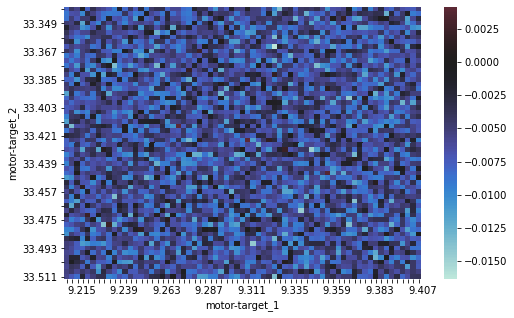

In [87]:
plt.figure(figsize = (8, 5));

# Clean up labels on horizontal-axis
plot1_labels = list(data['motor-target_1'].value_counts().sort_index().index)
plot2_labels = list(data['motor-target_2'].value_counts().sort_index().index)

hmap = sns.heatmap(data_to_plot1[5], cmap='icefire', xticklabels=plot1_labels, center=0);
plt.setp([hmap.get_xticklabels()[1::2], hmap.get_yticklabels()[::2]], visible=False);
plt.setp( hmap.get_xticklabels()[1::2], visible=False);
plt.setp( hmap.get_xticklabels()[1::2], visible=False);
plt.setp( hmap.get_xticklabels(), rotation = 0, rotation_mode='anchor', ha='left');

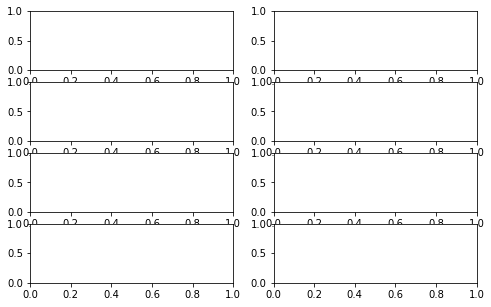

In [14]:
fig, ((ax0, ax1), (ax2, ax3), (ax4, ax5), (ax6, ax7)) = plt.subplots(nrows = 4, ncols = 2, figsize=(8, 5))

In [15]:
# Import AxesGrid toolkit to access plt helper classes
# axes_grid1 toolkit has helper classes
# for displaying multiple images in Matplotlib
from mpl_toolkits.axes_grid1 import AxesGrid

In [16]:
from mpl_toolkits.axes_grid1 import host_subplot

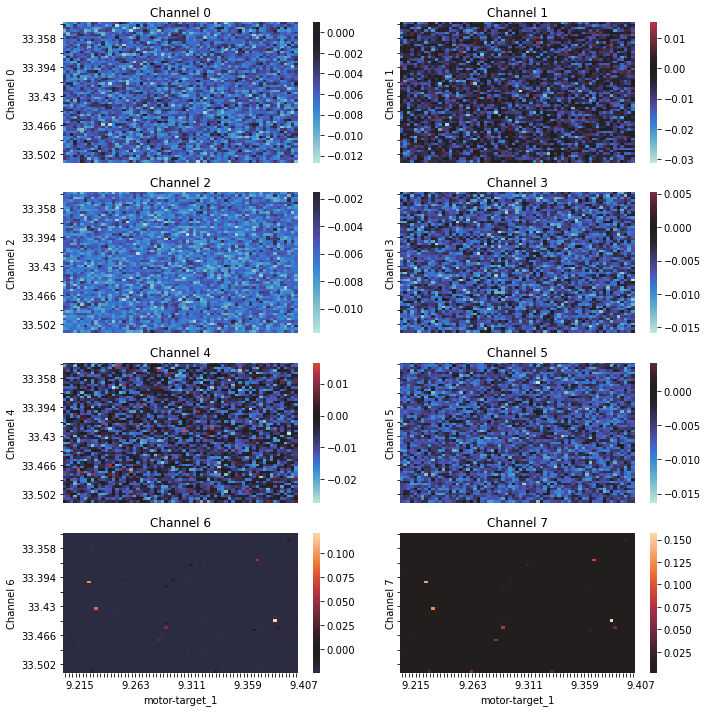

In [86]:
# Figsize probably needs to be generalized to remove hardcoded dimensions

fig, axs = plt.subplots(nrows = 4, ncols = 2, sharex= True, sharey=True, figsize=(10,10))

# Channels currently range from 0-7
channel = 0
# Define start of last row (figures displayed)
last_row = 6
# Identify min/max values in "signal-data"
#signal_df = data[['data_channel_0','data_channel_1','data_channel_2','data_channel_3','data_channel_4','data_channel_5','data_channel_6','data_channel_7']]
#v_min = min(signal_df.min())
#v_max = max(signal_df.max())

# Four rows may not always be desired
for row in range(0,4):
    # Two heatmaps side-by-side should generally be readible
    for col in range(0,2):
        # cmap chosen for ease of readability in diverging color palette
        hmap = sns.heatmap(data_to_plot1[channel], cmap='icefire', xticklabels=plot1_labels, center=0,ax=axs[row][col]);
        # Where should the CHANNEL be labeled?
        hmap.set_ylabel(f'Channel {channel}')
        hmap.set_title(f'Channel {channel}')
        # The vertical axis is shared in the call to subplots
        if channel%2==0:
            # Clean vertical axis with fewer labels displayed
            plt.setp(hmap.get_yticklabels()[::2], visible=False)
            
        #elif channel%2!=0:
            #plt.setp(hmap.get_yaxis(), visible=False);
            #plt.yticks(ticks=[])
            #hmap.set_yticks(ticks=[])
            
        # Horizontal axis is shared 
        if channel < last_row:
            hmap.set_xlabel('')
            plt.xticks(ticks=[])
            plt.setp([hmap.get_xaxis()], visible=False);
        # 
        if channel >= last_row:
            plt.setp([hmap.get_xticklabels()[1::2]], visible=False);
            plt.setp( hmap.get_xticklabels()[1::2], visible=False);
            plt.setp( hmap.get_xticklabels()[1::2], visible=False);
            plt.setp( hmap.get_xticklabels()[1::2], visible=False);
            plt.setp( hmap.get_xticklabels(), rotation = 0, rotation_mode='anchor', ha='left');
        channel += 1
plt.tight_layout()

In [26]:
data_cols = [col_name for col_name in data if 'data_channel' in col_name]
signal_df = data[data_cols]
data_cols

['data_channel_0',
 'data_channel_1',
 'data_channel_2',
 'data_channel_3',
 'data_channel_4',
 'data_channel_5',
 'data_channel_6',
 'data_channel_7']

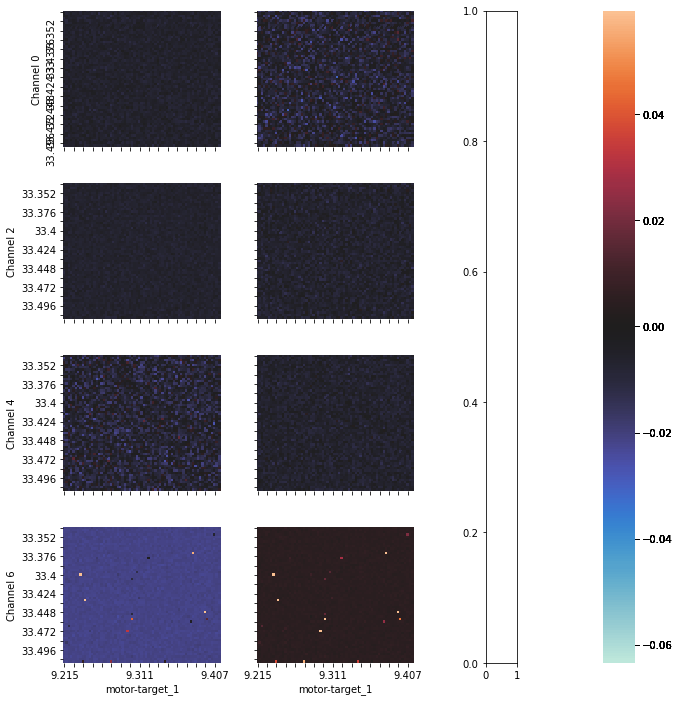

In [102]:
# Figsize probably needs to be generalized to remove hardcoded dimensions
fig = plt.figure(figsize=(16,12))

# Channels currently range from 0-7
channel = 0
# Identify min/max values in "signal-data"
# Re-write this code to give user easy option for selecting the two "dead" channels to exclude
signal_df = data[['data_channel_0','data_channel_1','data_channel_2','data_channel_3','data_channel_4','data_channel_5']]
v_min = min(signal_df.min())
v_max = max(signal_df.max())
#############################################################################################################################
grid = AxesGrid(fig, 
                111,
                label_mode = 'L',
                add_all = True, # False doesn't show subplots
                aspect = True, # False loses square shape
                #share_all=True,
                nrows_ncols=(4, 2),
                axes_pad=0.5,
                cbar_pad=1.0,
                #cbar_location='right',
                cbar_mode='single'
                )
#############################################################################################################################
for axs in grid:
    #axs.set_axis_off()
    # cmap chosen for ease of readability in diverging color palette
    hmap = sns.heatmap(data_to_plot1[channel],
                       ax=axs,
                       xticklabels=4,
                       yticklabels=4,
                       center = 0,
                       cmap='icefire',
                       vmin = v_min,
                       vmax=v_max);
    
        # Where should the CHANNEL be labeled?
    hmap.set_ylabel(f'Channel {channel}')

    # The vertical axis is shared in the call to subplots
    if (channel%2==0) | (channel==0):
        # Clean vertical axis with fewer labels displayed
        plt.setp(hmap.get_yticklabels()[::2], visible=False)
    #elif channel%2!=0:
        #plt.setp(hmap.get_yaxis(), visible=False);
        #plt.yticks(ticks=[])
        #hmap.set_yticks([])

    # Horizontal axis is shared 
    #if channel < last_row:
        #hmap.set_xlabel('')
        #plt.xticks(ticks=[])
        #plt.setp([hmap.get_xaxis()], visible=False);
    # 
    if channel >= last_row:
        plt.setp([hmap.get_xticklabels()[1::2]], visible=False);
        plt.setp( hmap.get_xticklabels()[1::2], visible=False);
        plt.setp( hmap.get_xticklabels()[1::2], visible=False);
        plt.setp(hmap.get_xticklabels(), 
                 #rotation_mode='anchor', 
                 #ha='left',
                 rotation = 0);
    # Increment to next channel and repeat for all 8 channels
    channel += 1

In [19]:
plt.figure(figsize = (12, 5));
plt.plot(data_to_plot1[('data_channel_0', 9.215)]);

TypeError: list indices must be integers or slices, not tuple

<Figure size 864x360 with 0 Axes>

In [ ]:
plt.plot(data_to_plot[('data_channel_0', 9.413)]);